In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
file_train='train_LZdllcl.csv'    #analytics Vidhya 
file_test='test_2umaH9m.csv'

In [2]:
df=pd.read_csv(file_train)
df_test=pd.read_csv(file_test)
df.head(4)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0


In [200]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [201]:
print(df.shape)
nullpc=df.isnull().sum()*100/df.shape[0]
nullpc.sort_values(ascending=False)

(54808, 14)


previous_year_rating    7.524449
education               4.395344
is_promoted             0.000000
avg_training_score      0.000000
awards_won?             0.000000
KPIs_met >80%           0.000000
length_of_service       0.000000
age                     0.000000
no_of_trainings         0.000000
recruitment_channel     0.000000
gender                  0.000000
region                  0.000000
department              0.000000
employee_id             0.000000
dtype: float64

In [202]:
print(df_test.shape)
nullpc=df_test.isnull().sum()*100/df.shape[0]
nullpc.sort_values(ascending=False)

(23490, 13)


previous_year_rating    3.306087
education               1.886586
avg_training_score      0.000000
awards_won?             0.000000
KPIs_met >80%           0.000000
length_of_service       0.000000
age                     0.000000
no_of_trainings         0.000000
recruitment_channel     0.000000
gender                  0.000000
region                  0.000000
department              0.000000
employee_id             0.000000
dtype: float64

<AxesSubplot:>

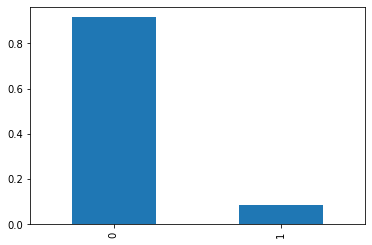

In [4]:
df.is_promoted.value_counts(normalize=True).plot(kind="bar")

In [203]:
df.rename(columns={'KPIs_met >80%': 'are_KPIs_met', 'awards_won?': 'were_awards_won'}, inplace=True)
df_test.rename(columns={'KPIs_met >80%': 'are_KPIs_met', 'awards_won?': 'were_awards_won'}, inplace=True)

<AxesSubplot:>

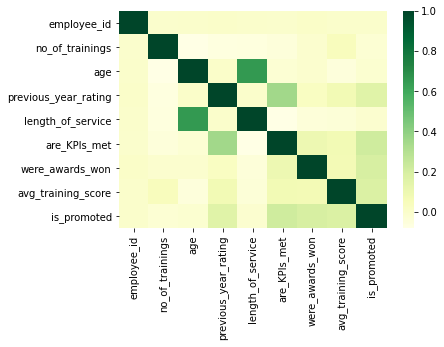

In [204]:
sns.heatmap(df.corr(), cmap="YlGn")

We see correlation between prev yr rating and KPIs met.

<AxesSubplot:xlabel='are_KPIs_met', ylabel='previous_year_rating'>

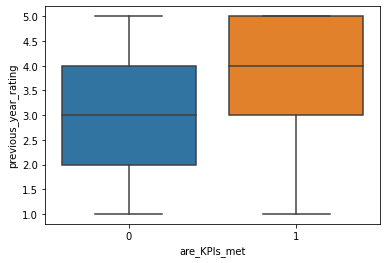

In [205]:
sns.boxplot(df.are_KPIs_met, df.previous_year_rating)

For KPIs_met = 1, previous rating median is 4 while not_met is 3.Lets use this to fill NAs for previous rating

In [206]:
def update_rating(kpi, rating):
    if rating == 'empty':
        if kpi == 1:
            return 4
        else:
            return 3
    else:
        return rating

In [207]:
df.previous_year_rating.fillna('empty', inplace=True)
df.previous_year_rating = df.apply(lambda x : update_rating(x['are_KPIs_met'], x['previous_year_rating']), axis=1)
df.previous_year_rating.isnull().sum()

0

In [208]:
df.education.value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [209]:
print(df.education.isna().sum())
df.education.fillna('Bachelor\'s', inplace=True)

2409


As bachelors are maximum in count we will replace nulls with Bachs

In [210]:
df.education.value_counts()

Bachelor's          39078
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

Target variable distribution

In [211]:
df.is_promoted.value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [212]:
df.education.value_counts()

Bachelor's          39078
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

<AxesSubplot:xlabel='education'>

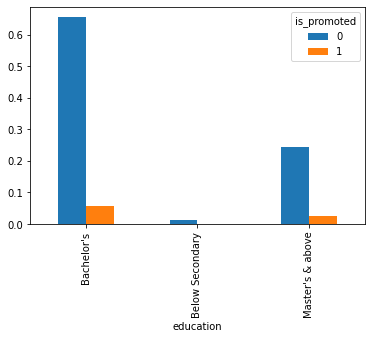

In [213]:
pd.crosstab(df.education, df.is_promoted, normalize=True).plot(kind="bar")

<AxesSubplot:xlabel='gender'>

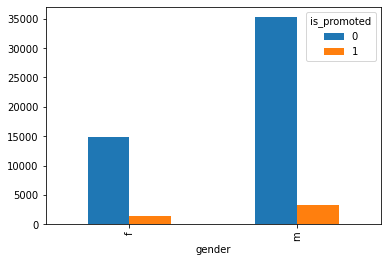

In [214]:
pd.crosstab(df.gender, df.is_promoted).plot(kind="bar")

In [216]:
df['are_KPIs_met'].value_counts()

0    35517
1    19291
Name: are_KPIs_met, dtype: int64

<AxesSubplot:xlabel='are_KPIs_met'>

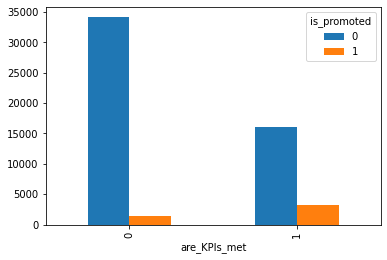

In [217]:
pd.crosstab(df['are_KPIs_met'], df.is_promoted).plot(kind="bar")

In [218]:
empcount_dep=df.groupby('department').employee_id.count().sort_values(ascending=False)
promotedcount_dep=df.groupby('department').is_promoted.sum().sort_values(ascending=False)


In [219]:
promoted_pc=pd.merge(empcount_dep,promotedcount_dep, how="inner", on=empcount_dep.index )
promoted_pc

,key_0,employee_id,is_promoted
0,Sales & Marketing,16840,1213
1,Operations,11348,1023
2,Technology,7138,768
3,Procurement,7138,688
4,Analytics,5352,512
5,Finance,2536,206
6,HR,2418,136
7,Legal,1039,69
8,R&D,999,53


In [220]:
promoted_pc['promoted_percent']=round(promoted_pc.is_promoted*100/promoted_pc.employee_id, 2)
promoted_pc

,key_0,employee_id,is_promoted,promoted_percent
0,Sales & Marketing,16840,1213,7.20
1,Operations,11348,1023,9.01
2,Technology,7138,768,10.76
3,Procurement,7138,688,9.64
4,Analytics,5352,512,9.57
5,Finance,2536,206,8.12
6,HR,2418,136,5.62
7,Legal,1039,69,6.64
8,R&D,999,53,5.31


<AxesSubplot:ylabel='department'>

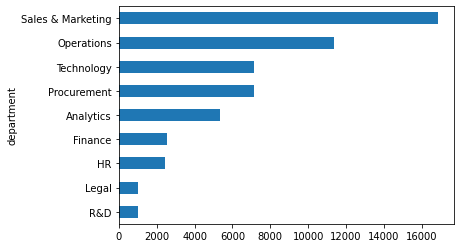

In [221]:
df.groupby('department').is_promoted.count().sort_values(ascending=True).plot(kind="barh")

<AxesSubplot:ylabel='department'>

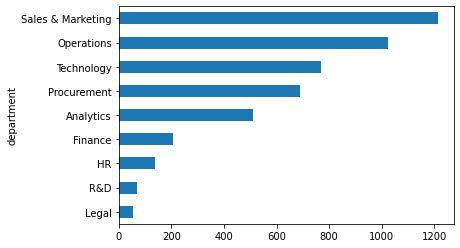

In [222]:
df.groupby('department').is_promoted.sum().sort_values(ascending=True).plot(kind="barh")

Count of employees regionwise

In [227]:
df.groupby('region').employee_id.count().sort_values(ascending=False).head(10)

region
region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
Name: employee_id, dtype: int64

In [226]:
df.groupby('region').is_promoted.sum().sort_values(ascending=False).head(10)

region
region_2     989
region_22    734
region_7     516
region_4     246
region_13    230
region_15    222
region_28    154
region_26    143
region_23    137
region_27    131
Name: is_promoted, dtype: int64

<AxesSubplot:xlabel='department'>

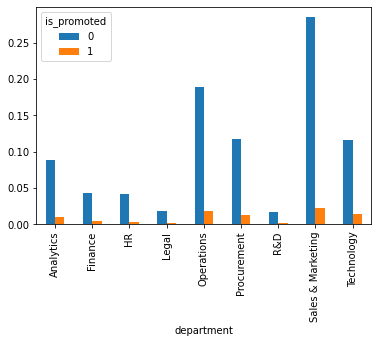

In [228]:
pd.crosstab(df.department, df.is_promoted, normalize=True).plot(kind="bar")

Understanding impact of previous_year_rating and is_promoted

<AxesSubplot:xlabel='is_promoted', ylabel='previous_year_rating'>

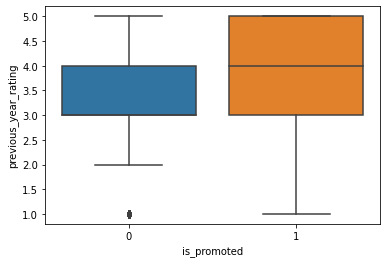

In [230]:
sns.boxplot(df.is_promoted,df.previous_year_rating)

##### Previous year rating if better, promotion probability is higher

### Training hrs/no of trainings

<AxesSubplot:xlabel='is_promoted', ylabel='avg_training_score'>

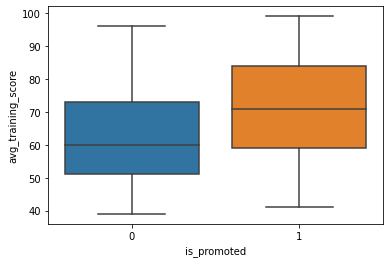

In [232]:
sns.boxplot(df.is_promoted, df.avg_training_score)

#### Higher avg_training score increases probability of promotion

<AxesSubplot:xlabel='is_promoted', ylabel='no_of_trainings'>

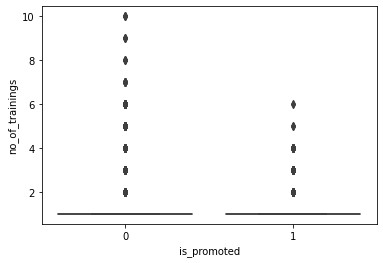

In [233]:
sns.boxplot(df.is_promoted, df.no_of_trainings)

In [234]:
pd.crosstab(df.no_of_trainings, df.is_promoted)

is_promoted,0,1
no_of_trainings,,
1,40468,3910
2,7382,605
3,1654,122
4,442,26
5,125,3
6,42,2
7,12,0
8,5,0
9,5,0


### length of service

<AxesSubplot:xlabel='is_promoted', ylabel='length_of_service'>

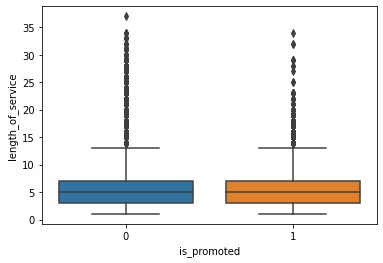

In [235]:
sns.boxplot(df.is_promoted, df.length_of_service)

length of service seems to have less impact on promotion

### Recruitment channel

In [239]:
df.recruitment_channel.value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [238]:
pd.crosstab(df.recruitment_channel, df.is_promoted)

is_promoted,0,1
recruitment_channel,,
other,27890,2556
referred,1004,138
sourcing,21246,1974


In [241]:
empcount_recruit=df.groupby('recruitment_channel').employee_id.count().sort_values(ascending=False)
promotedcount_recruit=df.groupby('recruitment_channel').is_promoted.sum().sort_values(ascending=False)
promoted_pc1=pd.merge(empcount_recruit, promotedcount_recruit, how="inner", on=empcount_recruit.index )
promoted_pc1

,key_0,employee_id,is_promoted
0,other,30446,2556
1,sourcing,23220,1974
2,referred,1142,138


In [243]:
promoted_pc1['promoted_percent']=round(promoted_pc1.is_promoted*100/promoted_pc1.employee_id, 2)
promoted_pc1

,key_0,employee_id,is_promoted,promoted_percent
0,other,30446,2556,8.40
1,sourcing,23220,1974,8.50
2,referred,1142,138,12.08


#### Recruitment through referrals results in greater possibility of promotion

### Age

<AxesSubplot:xlabel='is_promoted', ylabel='age'>

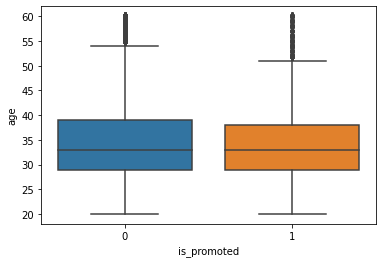

In [245]:
sns.boxplot(df.is_promoted, df.age)

Age doesnt seem to play a major role in promotion possibility

In [246]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'are_KPIs_met', 'were_awards_won',
       'avg_training_score', 'is_promoted'],
      dtype='object')

<AxesSubplot:ylabel='were_awards_won'>

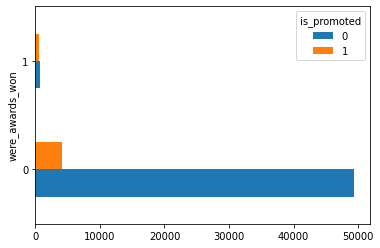

In [248]:
pd.crosstab(df.were_awards_won, df.is_promoted).plot(kind="barh")

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'are_KPIs_met'}>,
        <AxesSubplot:title={'center':'avg_training_score'}>],
       [<AxesSubplot:title={'center':'employee_id'}>,
        <AxesSubplot:title={'center':'is_promoted'}>,
        <AxesSubplot:title={'center':'length_of_service'}>],
       [<AxesSubplot:title={'center':'no_of_trainings'}>,
        <AxesSubplot:title={'center':'previous_year_rating'}>,
        <AxesSubplot:title={'center':'were_awards_won'}>]], dtype=object)

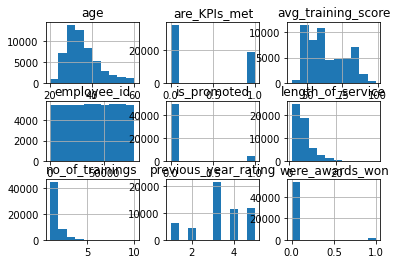

In [249]:
df.hist()

category=pd.cut(df.experience, bins=[0,0.9, 5, 12, 18, 23], labels=[1, 2, 3, 4, 5 ]) <br>
df.insert(1,'Exp_Grp',category)

traininghrs=pd.cut(df.training_hours, bins=[0,0.9, 5, 12, 18, 23], labels=[1, 2, 3, 4, 5 ]) 
df.insert(1,'train_hrs_bracket',traininghrs)

df.Exp_Grp.value_counts()
df.Exp_Grp=df.Exp_Grp.astype("int")
df.Exp_Grp.dtype

In [ ]:
(df.dtypes == 'object')

In [251]:
df.education.replace(to_replace=['Bachelor\'s', 'Master\'s & above', 'Below Secondary'], value=[1,2,3], inplace=True)
df.gender.replace(to_replace=['m','f'], value=[0, 1], inplace=True)
df.recruitment_channel.replace(to_replace=['other', 'sourcing', 'referred'], value=[1,2,3], inplace=True)
df.department.replace(to_replace=['Sales & Marketing', 'Operations', 'Procurement', 'Technology', 'Analytics', 'Finance', 'HR', 'Legal', 'R&D'], value=[1,2,3, 4, 5, 6, 7, 8, 9], inplace=True)

In [252]:
df.sample(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,are_KPIs_met,were_awards_won,avg_training_score,is_promoted
54073,56775,5,region_11,1,0,2,1,31,4.0,4,1,0,85,0
46556,24217,2,region_13,1,0,2,1,58,3.0,3,1,0,55,0
43968,52293,2,region_32,1,1,1,1,30,1.0,3,1,0,61,0


In [253]:
X=df[['department','education', 'gender','recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'are_KPIs_met', 'were_awards_won', 'avg_training_score',]]
y=df.is_promoted.values
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42, test_size=0.2)

Standardizing values

In [255]:
sc=StandardScaler()
#X_train=

In [256]:
lr=LogisticRegression(solver="liblinear")
lr.fit(X_train, y_train)
print(accuracy_score(y_test, lr.predict(X_test) ))
print(f1_score(y_test, lr.predict(X_test), average="weighted"))
print(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]) )

0.9244663382594417
0.8981792730296349
0.8134488410162215


In [257]:
svm_model=SVC(kernel="rbf", class_weight="balanced", probability=True)
svm_model.fit(X_train, y_train)
print(accuracy_score(y_test, svm_model.predict(X_test) ))
print(f1_score(y_test, svm_model.predict(X_test), average="weighted"))
print(roc_auc_score(y_test, svm_model.predict_proba(X_test)[:,1]) )

0.717296113847838
0.780014764766842
0.8219916963813907


In [258]:
dt=DecisionTreeClassifier(max_depth=5, class_weight="balanced",criterion="entropy")  # 
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print(accuracy_score(y_test,yhat  ))
print(f1_score(y_test, yhat, average="weighted"))
print(roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))
print(confusion_matrix(y_test, yhat))

0.6971355592045247
0.7650160274362039
0.8444603984299759
[[6850 3204]
 [ 116  792]]


In [259]:
rt=RandomForestClassifier(max_depth=4,n_estimators=100, class_weight="balanced",) #   
rt.fit(X_train, y_train)
yhat=rt.predict(X_test)
print(np.unique(yhat))
print(accuracy_score(y_test,yhat))
print(f1_score(y_test, yhat, average="weighted"))
print(roc_auc_score(y_test, rt.predict_proba(X_test)[:,1]) )
print(confusion_matrix(y_test, yhat))

[0 1]
0.6839080459770115
0.754830380061064
0.8351775960474233
[[6697 3357]
 [ 108  800]]


from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error

###### We define the model
model = xgb.XGBRegressor(objective='RMSE')
###### We train model
model.fit(X_train, y_train)
predictions = model.predict(X_test)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict(X_train))
metrics.auc(fpr, tpr)

In [ ]:
14381/4777

{"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] , <br>
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],<br>
 "min_child_weight" : [ 1, 3, 5, 7 ],<br>
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],<br>
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [267]:
import xgboost as xgb
xg_model=xgb.XGBRFClassifier(max_depth=15, n_estimators=500, scale_pos_weight=5)
xg_model.fit(X_train, y_train)
yhat=xg_model.predict(X_test)
print(np.unique(yhat))
print(accuracy_score(y_test,yhat))
print(f1_score(y_test, yhat, average="weighted"))
print(roc_auc_score(y_test, xg_model.predict_proba(X_test)[:,1]) )

#For imbalanced data, the argument changes; accuracy here is practically useless, and you should consider precision, recall, and the confusion matrix instead
print(confusion_matrix(y_test,yhat))

[0 1]
0.8977376391169495
0.9031465963275835
0.8979803663740034
[[9372  682]
 [ 439  469]]


In [278]:
from catboost import CatBoostClassifier
#scale_pos_weight is the ratio of number of negative class to the positive class. = (0's)/ 1s = 91/9
#xg_model=CatBoostClassifier(max_depth=7, n_estimators=1200, scale_pos_weight=8)
#xg_model=CatBoostClassifier(max_depth=5, n_estimators=1200, scale_pos_weight=5)
xg_model=CatBoostClassifier(max_depth=5, n_estimators=1200, scale_pos_weight=5)
xg_model.fit(X_train, y_train, verbose=False)
yhat=xg_model.predict(X_test)
print(f'accuracy: {accuracy_score(y_test,yhat)}')
print(f'f1 score: {f1_score(y_test, yhat, average="weighted")}')
print(f'test auc: {roc_auc_score(y_test, xg_model.predict_proba(X_test)[:,1])}')
#For imbalanced data, the argument changes; accuracy here is practically useless, and you should consider precision, recall, and the confusion matrix instead
print(confusion_matrix(y_test,yhat))

accuracy: 0.8838715562853494
f1 score: 0.8951410123718729
test auc: 0.9013648435014796
[[9161  893]
 [ 380  528]]


In [283]:
param = {'max_depth': [5, 6,7, 8, 9, 10, 11, 12], 
         'n_estimators':[500, 900, 1000, 1200, 1500], 
          'criterion' : ['gini', 'entropy'],
          'bootstrap':[True, False],
          'min_samples_leaf': [1,2,3,4]
        }
rnd_search = RandomizedSearchCV(RandomForestClassifier(), param, n_iter =10, cv=9)
rnd_search.fit(X_train,y_train)
rnd_search.best_params_
rnd_search.best_score_

0.9342698995889235

In [262]:
#n_estimators=i
#max_leaf_nodes -> [500,2000,8000,99999]:
dt=DecisionTreeClassifier(max_features=None,max_leaf_nodes=500, max_depth=5)
bagc=BaggingClassifier(base_estimator=dt,n_estimators=500,max_samples=100, n_jobs=7)
bagc.fit(X_train, y_train)
yhat=bagc.predict(X_test)
print(accuracy_score(y_test,yhat  ))
print(f1_score(y_test, yhat, average="weighted"))
print(roc_auc_score(y_test, bagc.predict_proba(X_test)[:,1]) )

0.9255610290093049
0.8972935360477796
0.8447757111597374


In [ ]:
#n_estimators=i
#max_leaf_nodes -> [500,2000,8000,99999]:
dt=DecisionTreeClassifier(max_features=None,max_leaf_nodes=500)
adab=AdaBoostClassifier(base_estimator=dt,n_estimators=100)
adab.fit(X_train, y_train)
yhat=adab.predict(X_test)
print(accuracy_score(y_test,yhat  ))
print(f1_score(y_test, yhat, average="weighted"))
print(roc_auc_score(y_test, adab.predict_proba(X_test)[:,1]) )